In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy import signal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

dr = '/Users/colinwageman/Desktop/DESKTOP/School/Cogs199/Recordings/Speller/'
file_1 = 'run_03.xdf'
file_2 = 'run_04.xdf'

# file 'run_03' contains data for spelling 'QUICK'
# file 'run_04' contains data for spelling 'P3EEG'

In [2]:
def speller_file_to_dict(data):
    run = {
        'data': [],
        'time_stamps': [],
        'aux': [],
        'aux_time_stamps': [],
        'markers': [],
        'marker_time_stamps': [],
        'sample_rate': {},
    }
    for stream in data:
        if stream['info']['name'][0] == 'eeg_data':
            run['data'] = stream['time_series']
            run['time_stamps'] = stream['time_stamps']
            run['sample_rate']['eeg'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'aux_data':
            run['aux'] = stream['time_series']
            run['aux_time_stamps'] = stream['time_stamps']
            run['sample_rate']['aux'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'P300_Speller_Markers':
            run['markers'] = stream['time_series']
            run['marker_time_stamps'] = stream['time_stamps']
        else:
            print('Warning unmatched stream name')
            
    return run

data = {
    'run': [],
}

for file_nm in [file_1, file_2]:
    imported_data, _ = pyxdf.load_xdf(dr+file_nm)
    run = speller_file_to_dict(imported_data)
    data['run'].append(run)
    
# print(data)

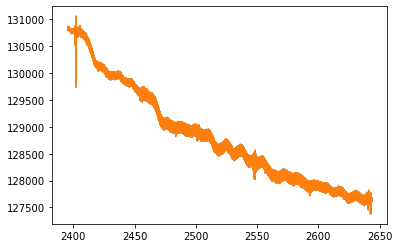

In [3]:
# re-ref test
ear_lobe = -(np.sum(data['run'][1]['data'], axis=1))/8
ref = data['run'][1]['data'][:,0] + ear_lobe
pz_before = data['run'][1]['data'][:,3]
pz_then = pz_before + ear_lobe
pz_after = pz_then - ref
pz_reref = pz_before - data['run'][1]['data'][:,0]
for_plot = np.array([pz_after, pz_reref]).T
_ = plt.plot(data['run'][1]['time_stamps'],  for_plot)

# re-ref HARD:
# extract online reference, add to channel, add to new ref, subtract new ref from channel
# re-ref EASY:
# subtract new ref channel from channels
# in the plot above/below, the two methods are compared and the same result is returned

In [4]:
def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel is not None else 'Time'
    ylabel = ylabel if ylabel is not None else 'Amplitude'
    title = title if title is not None else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend()
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
#             if (marker[0] == '1'):
            if '[' in marker[0]:
                ax.axvline(x=timestamp, color='C1')

In [5]:
# =====================
# Re Reference all data
# =====================
def re_reference(session_data, new_ref_ch_idx):
    # returns data with the new reference channel removed... because its zeros
    new_ref = session_data[:,new_ref_ch_idx]
    re_referenced = session_data - new_ref[:,None]
    re_referenced = np.delete(re_referenced, new_ref_ch_idx, axis=1)
    
    return re_referenced

# =====================
# Epochs and windowing
# =====================
def ms_to_samples(duration, rate=250):
    return int((duration/1000.0) * rate)

def get_samples_for_t_range(time_series, time_stamps, t_range, inclusive=False):
    # great for grabbing a window
    if inclusive:
        low_filt = time_stamps >= t_range[0]
    else:
        low_filt = time_stamps > t_range[0]
        
    high_filt = time_stamps < t_range[1]
    index_range = low_filt == high_filt
    data_range = time_series[index_range]
    ts_range = time_stamps[index_range]
    return data_range, ts_range

def get_epoch(data, data_times, stim_time, pre_stim_ms, post_stim_ms, sample_rate):
    # great for grabbing around a stimulus event time.
    
    # TODO: is there a faster way?
    i = (np.abs(data_times - stim_time)).argmin()
    start = i - ms_to_samples(pre_stim_ms, sample_rate)
    stop = i + ms_to_samples(post_stim_ms, sample_rate) + 1
    epoch = data[start:stop]
    
    return epoch


# ==========
# Epoch Prep
# ==========
def dc_offset(epoch_data, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    offset = np.mean(epoch_data, 0)

    return epoch_data - offset


def filter_eeg(epoch_data, sample_rate, f_range):
    # epoch_data should be 2D, (samples, channels)
    nyq = 0.5 * sample_rate
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, epoch_data, axis=0)    
    
    return np.array(sig_filt)

def baseline_center(epoch_data, baseline_duration_ms, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    baseline_samples = ms_to_samples(baseline_duration_ms, sample_rate)
    pre_stimulus = epoch_data[:baseline_samples]
    baseline = np.mean(pre_stimulus, 0)
    
    return epoch_data - baseline


# ================
# Speller Specific
# ================
ltr_key = ['ABCDEF',
           'GHIJKL',
           'MNOPQR',
           'STUVWX',
           'YZ1234',
           '56789_']

answer_key = {}
for i, row in enumerate(ltr_key):
    for j, ch in enumerate(row):
        answer_key[ch] = [i,j+6]
        
print(answer_key)

{'A': [0, 6], 'B': [0, 7], 'C': [0, 8], 'D': [0, 9], 'E': [0, 10], 'F': [0, 11], 'G': [1, 6], 'H': [1, 7], 'I': [1, 8], 'J': [1, 9], 'K': [1, 10], 'L': [1, 11], 'M': [2, 6], 'N': [2, 7], 'O': [2, 8], 'P': [2, 9], 'Q': [2, 10], 'R': [2, 11], 'S': [3, 6], 'T': [3, 7], 'U': [3, 8], 'V': [3, 9], 'W': [3, 10], 'X': [3, 11], 'Y': [4, 6], 'Z': [4, 7], '1': [4, 8], '2': [4, 9], '3': [4, 10], '4': [4, 11], '5': [5, 6], '6': [5, 7], '7': [5, 8], '8': [5, 9], '9': [5, 10], '_': [5, 11]}


In [6]:
def prepare_epochs(epochs, sample_rate):
    # epochs should be 3D, (event, samples, channels)
    
    # frequency range for bandpass filter, in Hz
    LOWCUT = 0.1
    HIGHCUT = 15.0
    freq_range = [LOWCUT,HIGHCUT]
    
    # baseline duration, in ms
    baseline_duration = 100
    
    prepped = []
    for epoch in epochs:
        temp_data = dc_offset(epoch, sample_rate)
        temp_data = filter_eeg(temp_data, sample_rate, freq_range)
        temp_data = baseline_center(temp_data, baseline_duration, sample_rate)
        prepped.append(temp_data)
        
    return np.array(prepped)

In [7]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']

# assigning data... a bit redundant but the hope is to help make the pipelining easier
run_1 = data['run'][0]
run_2 = data['run'][1]

r1_eeg = run_1['data']
r1_eeg_ts = run_1['time_stamps']
r1_aux = run_1['aux']
r1_aux_ts = run_1['aux_time_stamps']
r1_markers = run_1['markers']
r1_markers_ts = run_1['marker_time_stamps']

r2_eeg = run_2['data']
r2_eeg_ts = run_2['time_stamps']
r2_aux = run_2['aux']
r2_aux_ts = run_2['aux_time_stamps']
r2_markers = run_2['markers']
r2_markers_ts = run_2['marker_time_stamps']

new_ref_ch_idx = 0
r1_eeg = re_reference(r1_eeg, new_ref_ch_idx)
r2_eeg = re_reference(r2_eeg, new_ref_ch_idx)
del channels[new_ref_ch_idx]

# r1_eeg = filter_eeg(r1_eeg, 250, [0.1,15] )
# r2_eeg = filter_eeg(r2_eeg, 250, [0.1,15] )

# remove Fp1 channel
r1_eeg = np.delete(r1_eeg, -1, axis=1)
r2_eeg = np.delete(r2_eeg, -1, axis=1)
del channels[-1]

print(channels)
pz = channels.index('Pz')

['FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz']


### Scale Photosensor
During the first run the screen brightness wasn't as it's brightest. Here I scale it up so as to use the same threshold for each.

In [8]:
max_run1 = max(r1_aux[:,1])
max_run2 = max(r2_aux[:,1])
scaler = max_run2/max_run1
r1_aux[:,1] = r1_aux[:,1] * scaler

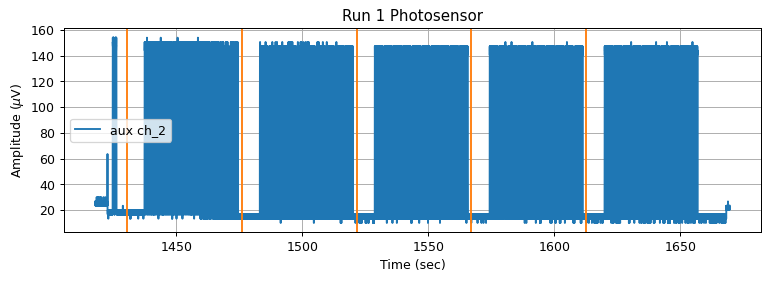

In [9]:
fig, ax = plot_time_series(
    X = r1_aux_ts,
    Y = r1_aux[:,1:2],
    labels = aux_chs[1:2],
    xlabel='Time (sec)',
    ylabel=r'Amplitude ($\mu$V)',
    title='Run 1 Photosensor'
)
add_markers_to_plot(r1_markers, r1_markers_ts, fig, ax)

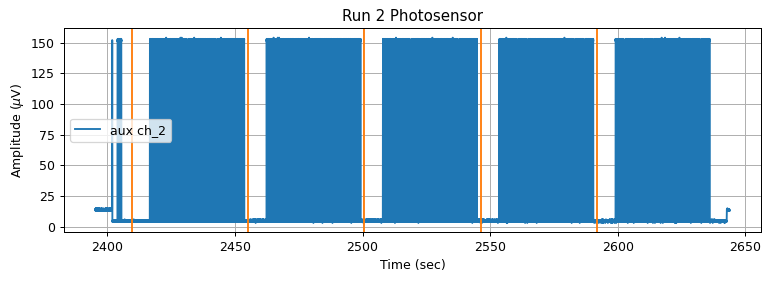

In [10]:
fig, ax = plot_time_series(
    X = r2_aux_ts,
    Y = r2_aux[:,1:2],
    labels = aux_chs[1:2],
    xlabel='Time (sec)',
    ylabel=r'Amplitude ($\mu$V)',
    title='Run 2 Photosensor'
)
add_markers_to_plot(r2_markers, r2_markers_ts, fig, ax)

### Sync photosensor with trials and organize markers

In [11]:
# clean and prep aux channel 0010010
# get associated markers and time stamps
# get trials of markers and time stamps
def get_ts_for_on_rise_threshold(data, data_ts, threshold):
    thr = (data > threshold) + 0
    rise = thr[1:] > thr[:-1]
    rise = np.insert(rise, 0, False) # accounts for lost position above
    return data_ts[rise]

PHOTO_SENSOR_THRESHOLD = 70 # this is based on a visual plot.
r1_photosensor_onsets = get_ts_for_on_rise_threshold(r1_aux[:,1], r1_aux_ts, PHOTO_SENSOR_THRESHOLD)
r2_photosensor_onsets = get_ts_for_on_rise_threshold(r2_aux[:,1], r2_aux_ts, PHOTO_SENSOR_THRESHOLD)

# We happen to know there are 600 stimulus onsets for these trials.
# 5 letters * 10 runs * 12 stimuli/rows_columns = 600
# TODO: automate this!
# There are 2 test sensor blinks that we can get rid of and there is a
# graphical blink at the very beginning of run 2 that needs to be removed.
r1_photosensor_onsets = r1_photosensor_onsets[2:]
r2_photosensor_onsets = r2_photosensor_onsets[3:]

def divide_markers(markers):
    # rc = row and column
    marker_collection = []
    target_collection = []
    y_collection = []
    for marker_arr in markers:
        marker = marker_arr[0]
        if '[' in marker:
            lbl = marker.split('[')[1].split(']')[0]
            target_collection.append(lbl)
            marker_collection.append([])
            y_collection.append([])
        elif marker.isnumeric():
            marker = int(marker)
            marker_collection[-1].append(marker)
            key = answer_key[target_collection[-1]]
            if marker in key:
                y_collection[-1].append(1)
            else:
                y_collection[-1].append(0)
                
    
    return target_collection, np.array(marker_collection), np.array(y_collection)

r1_target_ltr, r1_stim_markers, r1_y = divide_markers(r1_markers)
r2_target_ltr, r2_stim_markers, r2_y = divide_markers(r2_markers)

In [12]:
# Epoch durations in ms
PRE_STIM = 100
POST_STIM = 800

SAMPLE_RATE = 250.0 # Hz

# Make Epochs
r1_epochs = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_eeg, r1_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_epochs.append(epoch)
    
r2_epochs = []
for time in r2_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r2_eeg, r2_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r2_epochs.append(epoch)
    

# Prep Epochs
r1_epochs = prepare_epochs(r1_epochs, SAMPLE_RATE)
r2_epochs = prepare_epochs(r2_epochs, SAMPLE_RATE)

## Quick look at Pz Avg Target/Non-Target

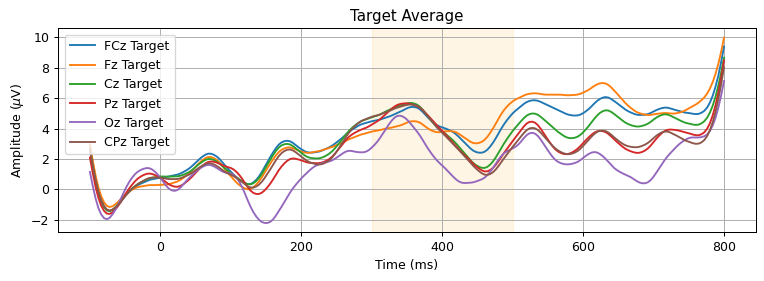

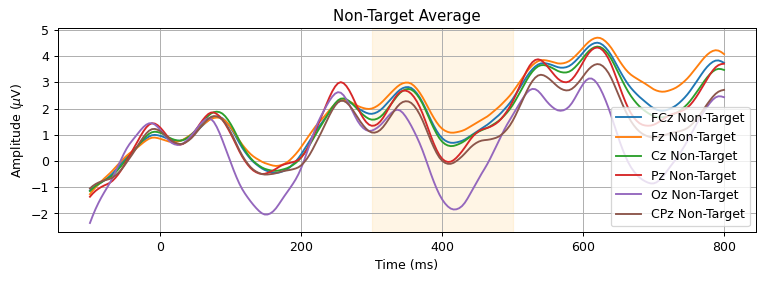

In [13]:
y = r2_y.flatten()
target_epochs = r2_epochs[y == 1]
non_target_epochs = r2_epochs[y == 0]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r2_epochs.shape[1])]

# average over epochs
# Pz_target_epoch_avg = np.mean(target_epochs[:,:,pz], axis=0)
# Pz_non_target_epoch_avg = np.mean(non_target_epochs[:,:,pz], axis=0)

# fig, ax = plt.subplots(figsize = (10, 5), dpi = 90)
# ax.axvspan(300, 500, color='orange', alpha=0.1)

# ax.plot(x_for_plot, Pz_target_epoch_avg, label=f'{channels[pz]} Target avg.')
# ax.plot(x_for_plot, Pz_non_target_epoch_avg, label=f'{channels[pz]} Non-Target avg.')

# ax.set_xlabel('Time (ms)')
# ax.set_ylabel(r'Amplitude ($\mu$V)')
# ax.set_title(f'{channels[pz]} Average')
# ax.grid(True)
# _ = ax.legend()

target_epoch_avg = np.mean(target_epochs, axis=0)*-1
non_target_epoch_avg = np.mean(non_target_epochs, axis=0)*-1

# aux_epoch_avg = np.mean(r1_aux_epochs[:,:,1], axis=0)

# ch_avg = np.hstack((target_epoch_avg, non_target_epoch_avg))

# g_labels = [ch + 'Target' for ch in channels] + [ch + 'Non-Target' for ch in channels]
# fig, ax = plot_time_series(
#     x_for_plot,
#     ch_avg,
#     labels = g_labels,
#     xlabel='Time (ms)',
#     ylabel=r'Amplitude ($\mu$V)',
#     title=f'Channel Average'
# )
# _ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = [ch + ' Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = [ch + ' Non-Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    non_target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Non-Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

In [14]:
# notes: markers ahead of photosensor. No photosensor for '[P]3EEG'
# first aux blink is red flash = trash
# calibration blinks are 1s apart, followed by ~12s
print(r2_markers[:4])
print(r2_markers_ts[:4])
print(r2_photosensor_onsets[:2])

[['P3EEG'], ['[P]3EEG'], ['4'], ['6']]
[2400.80030268 2409.50471681 2415.57397392 2415.85420843]
[2416.5967905 2416.8807906]


In [20]:
Y = r2_y.flatten()
Y2 = r1_y.flatten()

X_Pz = r2_epochs[:,:,pz]
X2_Pz = r1_epochs[:,:,pz]

def balance_zeros(data, y):
    # truncates the zeros down to the same size as ones.
    # assumes more zeros than ones
    zeros = np.sum(y == 0)
    ones = np.sum(y == 1)
    step = int(zeros/ones)
#     print(f'{100*zeros/Y.shape[0]:.2f}% zeros')
    sort_order = np.argsort(y, kind='stable')
    half_zeros = [i for i in range(0,zeros,step)]
    sort_order = np.concatenate((sort_order[half_zeros], sort_order[-ones:]), axis=0)
    orig_order = np.sort(sort_order)
    y_part = y[orig_order]
    data_part = data[orig_order]
    
    return data_part, y_part
#     return data, y

X_Pz_trunc, y_trunc = balance_zeros(X_Pz, Y)
X2_Pz_trunc, y2_trunc = balance_zeros(X2_Pz, Y2)

X_Pz_comb = np.concatenate((X_Pz_trunc, X2_Pz_trunc))
y2_comb = np.concatenate((y_trunc, y2_trunc))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_Pz_comb, y2_comb, test_size=0.20, random_state=24)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

Simple 20% test split accuracy: 0.5375


In [17]:
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cross_val_score(LDA_clf, X_Pz_comb, y2_comb, cv = 5)
print(f'Cross Validataion scores: {scores}')

Cross Validataion scores: [0.575  0.55   0.5    0.5625 0.525 ]


## Online Simulation
Using the first letter runs to train the LDA classifier, then test on the last letter. This can be randomized and performed for each letter.
Probably just using one electrode...Pz

In [21]:
def window_and_combine_features(epochs, sub_samples_per_ch):
    # epochs is expected to be 3D, (epoch, sample, channel)
    epoch_len = epochs.shape[1]
    window_len = np.round(epoch_len/sub_samples_per_ch).astype(int)
    windowed = np.zeros(( len(epochs), epochs.shape[-1], sub_samples_per_ch))
    
    for i in range(sub_samples_per_ch):
        win_start = i * window_len
        win_stop = win_start + window_len
        win_avg = np.mean(epochs[:,win_start:win_stop,:], axis=1) # (epochs x ch)
        windowed[:,:,i] = win_avg

    windowed = windowed.reshape((len(epochs), epochs.shape[-1] * sub_samples_per_ch))

    return windowed

def test_LDA_prediction(target_ltrs, stim_labels, epochs, y, channel):
    for i, target_ltr in enumerate(target_ltrs):
        test_epoch = epochs[i]
        test_stim_labels = stim_labels[i]
        test_y = y[i]
        train_epochs = np.delete(epochs, i, 0)
        train_stim_labels = np.delete(stim_labels, i, 0)
        train_y = np.delete(y, i, 0)
        train_y = train_y.flatten()
        
        shp = train_epochs.shape

        if channel is not None:
            test_epoch = test_epoch[:,:,channel]
            train_x = train_epochs.reshape(shp[0] * shp[1], shp[2], shp[3])
            train_x = train_x[:,:,channel]
        else:
            train_x = train_epochs.reshape(shp[0] * shp[1], shp[2])
        
        train_x, train_y = balance_zeros(train_x, train_y)
        LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        LDA_clf = LDA_clf.fit(train_x, train_y)
        print(f'classifier score: {LDA_clf.score(test_epoch, test_y)}')
        
        confidence = LDA_clf.predict_proba(test_epoch)

        conf_avg = []
        for j in range(len(ltr_key)*2):
            avg = np.mean(confidence[test_stim_labels == j, 1])
            conf_avg.append(avg)
            
#         print(conf_avg)
            
        conf_avg_rows = conf_avg[:len(ltr_key)]
        conf_avg_cols = conf_avg[len(ltr_key):]
        
        max_row = np.argmax(conf_avg_rows)
        max_col = np.argmax(conf_avg_cols)
        print(f'-- Run: {i}, Results --')
        print(f'row choice: {max_row}, column choice: {max_col}')
        result = ltr_key[max_row][max_col]
#         print(result == target_ltr)
        print(result, target_ltr)

In [24]:
# **************************
# run 2 - test
# **************************

# r2_target_ltr, r2_stim_markers, r2_y, r2_epochs
# dims: (5)    , (5,120)       , (5,120), (600,226,7)
# we need the epochs to match the 5x120 instead of 600
# so reshape(5,120,266,7) 
# shp = r2_stim_markers.shape + r2_epochs.shape[1:]
# r2_epochs_by_target = np.reshape(r2_epochs, shp)

# r2_win_epochs = window_and_combine_features(r2_epochs, 5)
# shp = r2_stim_markers.shape + r2_win_epochs.shape[-1:]
# r2_win_epochs_by_target = np.reshape(r2_win_epochs, shp)

# print('\n==== vv NON-WINDOWED vv ====\n')
# test_LDA_prediction(r2_target_ltr, r2_stim_markers, r2_epochs_by_target, r2_y, pz)
# print('\n==== vv WINDOWED vv ====\n')
# test_LDA_prediction(r2_target_ltr, r2_stim_markers, r2_win_epochs_by_target, r2_y, None)

# **************************
# combined run - test
# **************************

all_markers = np.concatenate((r1_markers, r2_markers))
all_target_ltr, all_stim_markers, all_y = divide_markers(all_markers)

all_epochs = np.concatenate((r1_epochs, r2_epochs))

shp = all_stim_markers.shape + all_epochs.shape[1:]
all_epochs_by_target = np.reshape(all_epochs, shp)

all_win_epochs = window_and_combine_features(all_epochs, 5)
shp = all_stim_markers.shape + all_win_epochs.shape[-1:]
all_win_epochs_by_target = np.reshape(all_win_epochs, shp)

print('\n==== vv NON-WINDOWED vv ====\n')
test_LDA_prediction(all_target_ltr, all_stim_markers, all_epochs_by_target, all_y, pz)
print('\n==== vv WINDOWED vv ====\n')
test_LDA_prediction(all_target_ltr, all_stim_markers, all_win_epochs_by_target, all_y, None)

# **************************
# run 1 - test
# **************************

# shp = r1_stim_markers.shape + r1_epochs.shape[1:]
# r1_epochs_by_target = np.reshape(r1_epochs, shp)

# r1_win_epochs = window_and_combine_features(r1_epochs, 5)
# shp = r1_stim_markers.shape + r1_win_epochs.shape[-1:]
# r1_win_epochs_by_target = np.reshape(r1_win_epochs, shp)

# test_LDA_prediction(r1_target_ltr, r1_stim_markers, r1_epochs_by_target, r1_y, pz)
# print('\n==== vv WINDOWED vv ====\n')
# test_LDA_prediction(r1_target_ltr, r1_stim_markers, r1_win_epochs_by_target, r1_y, None)


==== vv NON-WINDOWED vv ====

classifier score: 0.45
-- Run: 0, Results --
row choice: 4, column choice: 4
3 Q
classifier score: 0.36666666666666664
-- Run: 1, Results --
row choice: 5, column choice: 5
_ U
classifier score: 0.5083333333333333
-- Run: 2, Results --
row choice: 4, column choice: 2
1 I
classifier score: 0.38333333333333336
-- Run: 3, Results --
row choice: 1, column choice: 0
G C
classifier score: 0.5416666666666666
-- Run: 4, Results --
row choice: 1, column choice: 3
J K
classifier score: 0.6166666666666667
-- Run: 5, Results --
row choice: 5, column choice: 3
8 P
classifier score: 0.6083333333333333
-- Run: 6, Results --
row choice: 1, column choice: 1
H 3
classifier score: 0.5833333333333334
-- Run: 7, Results --
row choice: 5, column choice: 4
9 E
classifier score: 0.6083333333333333
-- Run: 8, Results --
row choice: 0, column choice: 0
A E
classifier score: 0.55
-- Run: 9, Results --
row choice: 1, column choice: 5
L G

==== vv WINDOWED vv ====

classifier score: 